In [ ]:
import numpy as np
import cv2
from scipy import ndimage
from PIL import Image
import matplotlib.pyplot as plt
import skimage
from skimage import filters as skifilters
%matplotlib inline
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
def color_constant(img):
    # Extract Color Channels
    img_R = img[:,:,0]
    img_G = img[:,:,1]
    img_B = img[:,:,2]    
    
    # Calculate Channel Averages
    avg_R = np.mean(img_R)
    avg_G = np.mean(img_G)
    avg_B = np.mean(img_B)
    avg_all = np.mean(img)
    
    # Calculate Scaling Factor for White-Balance
    scale_R = (avg_all / avg_R)
    scale_G = (avg_all / avg_G)
    scale_B = (avg_all / avg_B)
    
    # Transform to White-Balance
    img_new = np.zeros(img.shape)
    img_new[:,:,0] = scale_R * img_R  
    img_new[:,:,1] = scale_G * img_G 
    img_new[:,:,2] = scale_B * img_B  
    
    # Normalize Images
    max_intensity = (np.max(img_new))
    min_intensity = (np.min(img_new))
    
    img_normalized = (((img_new - min_intensity) / (max_intensity - min_intensity))*255).astype(np.uint8)

    # Illuminant Profile (Gray World Color Constancy) 
    illuminance = [avg_R, avg_G, avg_B]
    
    return img_normalized, illuminance


def white_balance(img):
    # White Balance in LAB Color Space
    result = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)                                             
    avg_a  = np.average(result[:, :, 1])
    avg_b  = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) )      
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) )      
    result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
    return result


def clahe_LAB(img,clip=0.9,tile=1):
    # Contrast Limited Adaptive Histogram Equalization in LAB Color Space
    lab        = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)                          
    clahe      = cv2.createCLAHE(clipLimit=clip, tileGridSize=(tile,tile))     
    lab[:,:,0] = clahe.apply(lab[:,:,0])                                       
    output     = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)                          
    return output




def occlusion_removal(img,threshold=20,SE_radius=13,minArea=50000):
    # Remove Dark Hair Occlusions in Dermatoscopic Images via LUV Color Space
    luv       = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)

    # Morphological Closing via Spherical SE
    kernel    = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(SE_radius,SE_radius))
    closing   = cv2.morphologyEx(luv, cv2.MORPH_CLOSE, kernel)

    # Generate Masks via Hysteresis Thresholding Difference Image in L Channel
    diffc      = closing[:,:,0]-luv[:,:,0]
    maskc      = (skifilters.apply_hysteresis_threshold(diffc,threshold,80)).astype(np.uint8)*255
    
    # Remove Side Components
    label_im, nb_labels = ndimage.label(maskc)
    sizes               = ndimage.sum(maskc, label_im, range(nb_labels + 1))
    temp_mask           = sizes > minArea
    maskc               = (temp_mask[label_im]*255).astype(np.uint8)
  
    mask_3dc   = maskc[:,:,None] * np.ones(3,dtype=np.uint8)[None, None, :]
    basec      = cv2.bitwise_not(maskc)
    base_3dc   = basec[:,:,None] * np.ones(3,dtype=np.uint8)[None, None, :]

    # Restitch Preprocessed Image
    preimagec  = ((base_3dc/255)*luv).astype(np.uint8)
    postimagec = ((mask_3dc/255)*closing).astype(np.uint8)
    fullc      = preimagec + postimagec
    outputc    = cv2.cvtColor(fullc, cv2.COLOR_Luv2RGB)

    return outputc, maskc


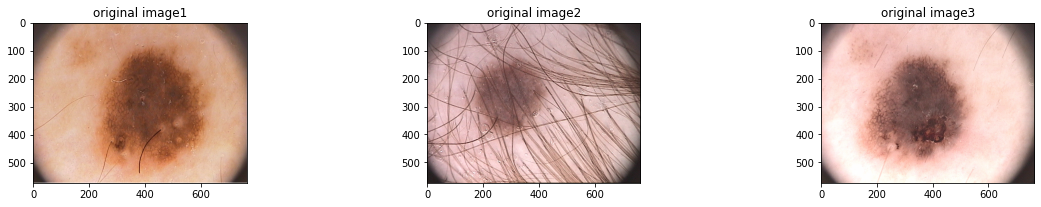

In [46]:
image_path ="/content/drive/Shareddrives/Ridhi & Rahul/CVIP Workshop /Ridhi/trainx/"   # path for taking input from the google drive
# image_path = "D:/Ridhi/WCVIP 2020 FILES"           
# image_path = "drive/My Drive/Ridhi/WCVIP_2020"

img1 = Image.open(image_path + '/IMD002.bmp') 
img2 = Image.open(image_path + '/IMD003.bmp') 
img3 = Image.open(image_path + '/IMD004.bmp') 

# Output Images

plt.figure(figsize=[20,10]) 

plt.subplot(331), plt.imshow(img1), plt.title('original image1')
plt.subplot(332), plt.imshow(img2), plt.title('original image2')
plt.subplot(333), plt.imshow(img3), plt.title('original image3')

sample1 = np.array(img1)
sample2 = np.array(img2)
sample3 = np.array(img3)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2804fb2748>,
 <matplotlib.image.AxesImage at 0x7f2804fa50b8>)

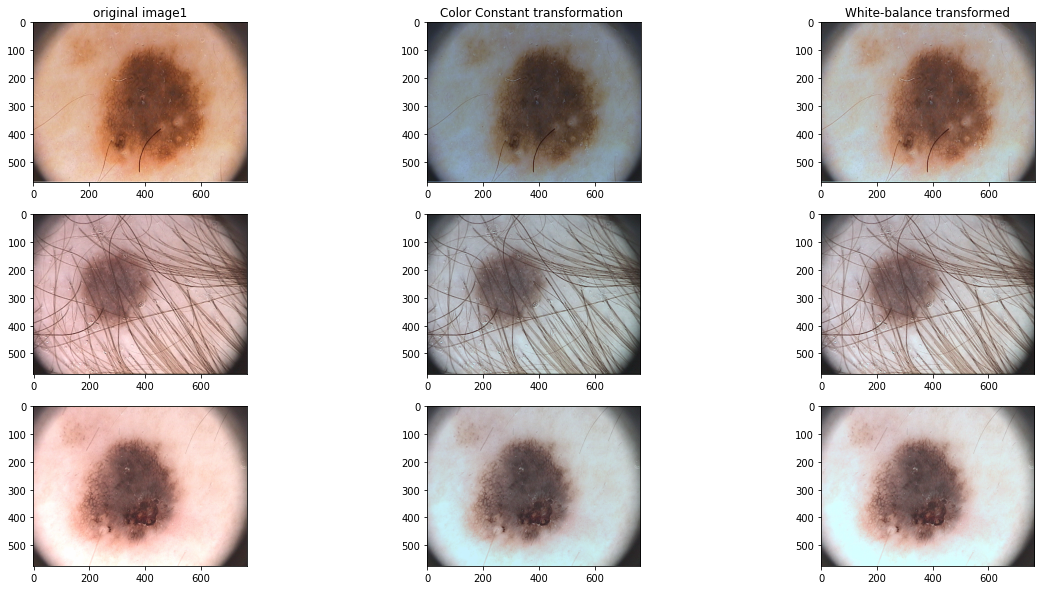

In [47]:
# Color-Constant Transformation
cc1,_ = color_constant(sample1)
cc2,_ = color_constant(sample2)
cc3,_ = color_constant(sample3)

# White-Balance Transformation
wb11 = white_balance(sample1)
wb22 = white_balance(sample2)
wb33 = white_balance(sample3)


plt.figure(figsize=[20,10])
plt.subplot(331),    plt.imshow(sample1), plt.title('original image1')
plt.subplot(332),    plt.imshow(cc1), plt.title('Color Constant transformation ')
plt.subplot(333),    plt.imshow(wb11), plt.title('White-balance transformed')

plt.subplot(334),    plt.imshow(sample2)
plt.subplot(335),    plt.imshow(cc2)
plt.subplot(336),    plt.imshow(wb22)

plt.subplot(337), plt.imshow(sample3)
plt.subplot(338), plt.imshow(cc3)
plt.subplot(339), plt.imshow(wb33)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2805968748>,
 <matplotlib.image.AxesImage at 0x7f28059004a8>)

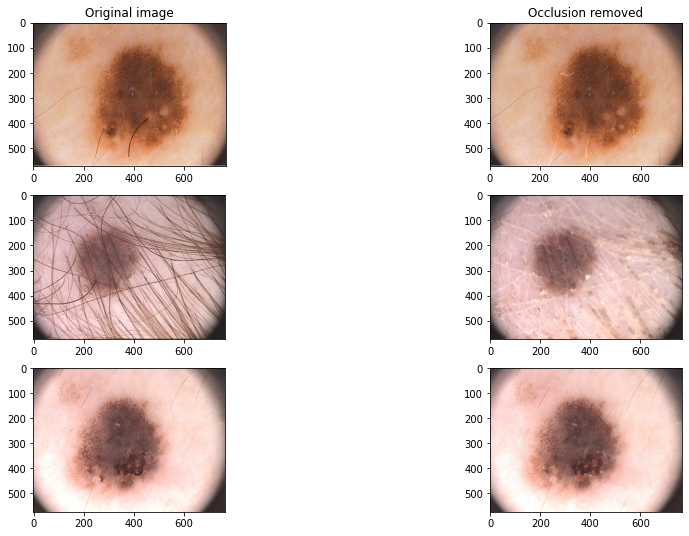

In [48]:
# Occlusion Removal
hr1,mask1 = occlusion_removal(sample1)
hr2,mask2 = occlusion_removal(sample2)
hr3,mask3 = occlusion_removal(sample3)


plt.figure(figsize=[15,9])
plt.subplot(321),    plt.imshow(sample1), plt.title('Original image')
plt.subplot(322),    plt.imshow(hr1), plt.title('Occlusion removed')
plt.subplot(323),    plt.imshow(sample2)
plt.subplot(324),    plt.imshow(hr2)
plt.subplot(325),    plt.imshow(sample3)
plt.subplot(326),    plt.imshow(hr3)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2804c97198>,
 <matplotlib.image.AxesImage at 0x7f2804bfbb00>)

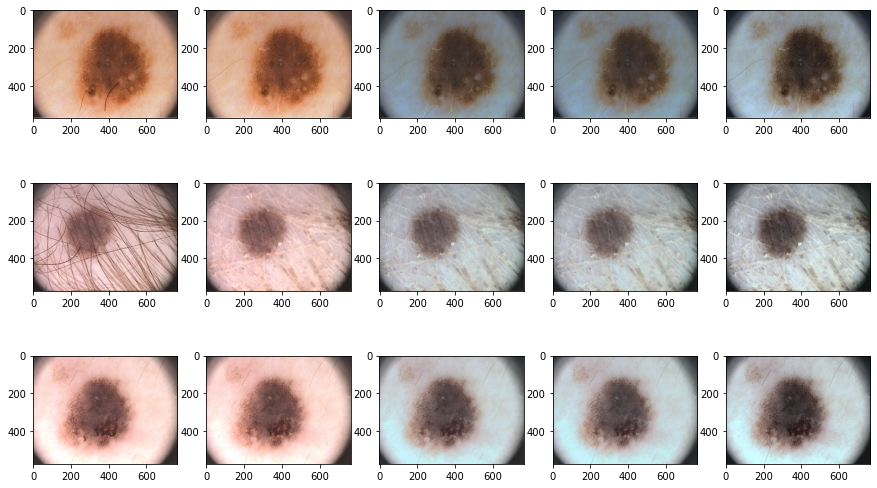

In [49]:
# Occlusion Removal
hr1,mask1 = occlusion_removal(sample1)
hr2,mask2 = occlusion_removal(sample2)
hr3,mask3 = occlusion_removal(sample3)


# Color-Constant Transformation
cc1,_ = color_constant(hr1)
cc2,_ = color_constant(hr2)
cc31,_ = color_constant(hr3)


# White-Balance Transformation
wb1 = white_balance(cc1)
wb2 = white_balance(cc2)
wb3 = white_balance(cc31)


# CLAHE Preprocessing
cl1   = clahe_LAB(wb1)
cl2   = clahe_LAB(wb2)
cl3   = clahe_LAB(wb3)


plt.figure(figsize=[15,9])
plt.subplot(351),    plt.imshow(sample1)
plt.subplot(352),    plt.imshow(hr1)
plt.subplot(353),    plt.imshow(cc1)
plt.subplot(354),    plt.imshow(wb1)
plt.subplot(355),    plt.imshow(cl1)

plt.subplot(356),    plt.imshow(sample2)
plt.subplot(357),    plt.imshow(hr2)
plt.subplot(358),    plt.imshow(cc2)
plt.subplot(359),    plt.imshow(wb2)
plt.subplot(3,5,10),    plt.imshow(cl2)

plt.subplot(3,5,11),    plt.imshow(sample3)
plt.subplot(3,5,12), plt.imshow(hr3)
plt.subplot(3,5,13), plt.imshow(cc31)
plt.subplot(3,5,14), plt.imshow(wb3)
plt.subplot(3,5,15),    plt.imshow(cl3)

# For saving the pre-processed image
# im1 = Image.fromarray(cl1)
# im1.save(image_path + "/saved_image1.bmp")